# Importing Libraries
PyRosetta is the main library of interest, used for predicting the three-dimensional structures of proteins, as well as for analysing protein structures and enabling to understand the folding process and the structure-function relationship in proteins.


In [22]:
import pyrosetta
pyrosetta.init()
from pyrosetta.teaching import *
from pyrosetta import *
import csv
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyrosetta.rosetta.core.pack.rotamer_set import RotamerSets
from pyrosetta.rosetta.core.pack.task import TaskFactory
from pyrosetta.rosetta.core.pack.rotamer_set import *
from pyrosetta.rosetta.core.pack.interaction_graph import InteractionGraphFactory
from pyrosetta.rosetta.core.pack.task import *
from pyrosetta import PyMOLMover

PyRosetta-4 2023 [Rosetta PyRosetta4.Release.python310.mac 2023.38+release.52c4cf62073872b07f5cf0623533318b147b5910 2023-09-19T15:49:21] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python310.mac r358 2023.38+release.52c4cf62073 52c4cf62073872b07f5cf0623533318b147b5910 http://www.pyrosetta.org 2023-09-19T15:49:21
core.init: command: PyRosetta -ex1 -ex2aro -database /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyrosetta-2023.38+release.52c4cf62073-py3.10-macosx-10.9-universal2.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=597626897 seed_offset=0 real_seed=597626897
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=597626897 RG_type=mt19937


# Loading Protein File
Import pdb file of protein structure, evaluate energy of structure, test all possible conformations, generate energies in interaction graph

In [23]:
# Initiate structure, scorefunction
pose = pyrosetta.pose_from_pdb("Input Files/test1.pdb")


residue_count = pose.total_residue()
sfxn = get_score_function(True)
print(pose.sequence())
print(residue_count)


relax_protocol = pyrosetta.rosetta.protocols.relax.FastRelax()
relax_protocol.set_scorefxn(sfxn)
relax_protocol.apply(pose)

# Define task, interaction graph and rotamer sets (model_protein_csv.py)
task_pack = TaskFactory.create_packer_task(pose) 

rotsets = RotamerSets()
pose.update_residue_neighbors()
sfxn.setup_for_packing(pose, task_pack.designing_residues(), task_pack.designing_residues())
packer_neighbor_graph = pyrosetta.rosetta.core.pack.create_packer_graph(pose, sfxn, task_pack)
rotsets.set_task(task_pack)
rotsets.build_rotamers(pose, sfxn, packer_neighbor_graph)
rotsets.prepare_sets_for_packing(pose, sfxn) 
ig = InteractionGraphFactory.create_interaction_graph(task_pack, rotsets, pose, sfxn, packer_neighbor_graph)
print("built", rotsets.nrotamers(), "rotamers at", rotsets.nmoltenres(), "positions.")
rotsets.compute_energies(pose, sfxn, packer_neighbor_graph, ig, 1)

# Output structure to be visualised in pymol
pose.dump_pdb("output_repacked.pdb")

core.import_pose.import_pose: File 'test1.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 6 atoms at position 1 in file test1.pdb. Best match rsd_type:  ALA:NtermProteinFull
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 13 atoms at position 2 in file test1.pdb. Best match rsd_type:  LYS
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 5 atoms at position 3 in file test1.pdb. Best match rsd_type:  ALA
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 5 atoms at position 4 in file test1.pdb. Best match rsd_type:  ALA:CtermProteinFull
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue ALA:CtermProteinFull 4
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
AKAA
4
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015
protocols.relax.FastRelax: CMD: repeat  13.3121  0  0  0.55
protocols.relax.FastRelax: CMD: coord_cst_weight  13.3121  0  

True

# Generate energy files
Define matrix dimensions and create output files in which to load the data for the next steps.

In [24]:
# Define dimension for matrix
max_rotamers = 0
for residue_number in range(1, residue_count+1):
    n_rots = rotsets.nrotamers_for_moltenres(residue_number)
    print(f"Residue {residue_number} has {n_rots} rotamers.")
    if n_rots > max_rotamers:
        max_rotamers = n_rots

print("Maximum number of rotamers:", max_rotamers)

# Define matrices in which to load the values
E = np.zeros((max_rotamers, max_rotamers))
Hamiltonian = np.zeros((max_rotamers, max_rotamers))

E1 = np.zeros((max_rotamers, max_rotamers))
Hamiltonian1 = np.zeros((max_rotamers, max_rotamers))

# Generate output files
output_file = "Energy Files/two_body_terms.csv"
output_file1 = "Energy Files/one_body_terms.csv"
data_list = []
data_list1 = []
df = pd.DataFrame(columns=['res i', 'res j', 'rot A_i', 'rot B_j', 'E_ij'])
df1 = pd.DataFrame(columns=['res i', 'rot A_i', 'E_ii'])

Residue 1 has 235 rotamers.
Residue 2 has 277 rotamers.
Residue 3 has 342 rotamers.
Residue 4 has 206 rotamers.
Maximum number of rotamers: 342


# Visualisation of structure after repacking with rotamers
Using PyMOL the 3D protein structure can be visualised, once the hydrogen bonds have been re-integrated.

In [25]:
pmm = PyMOLMover()
clone_pose = Pose()
clone_pose.assign(pose)
pmm.apply(clone_pose)
pmm.send_hbonds(clone_pose)
pmm.keep_history(True)
pmm.apply(clone_pose)

# Save one and two body energies to output files
Extract the one-body and two-body energies from the interaction graph and save them in the output csv files with all the rotamers of the 2 residue protein. Looping through all of the residues in two seperate loops.

In [26]:
# to limit to 2 rotamers per residue
num_rot = 4

# Loop to find Hamiltonian values Jij - interaction of rotamers on NN residues
for residue_number in range(1, residue_count):
    rotamer_set_i = rotsets.rotamer_set_for_residue(residue_number)
    if rotamer_set_i == None:
        continue

    residue_number2 = residue_number + 1
    residue2 = pose.residue(residue_number2)
    rotamer_set_j = rotsets.rotamer_set_for_residue(residue_number2)
    if rotamer_set_j == None:
        continue

    molten_res_i = rotsets.resid_2_moltenres(residue_number)
    molten_res_j = rotsets.resid_2_moltenres(residue_number2)

    edge_exists = ig.find_edge(molten_res_i, molten_res_j)
        
    if not edge_exists:
            continue
    
    for rot_i in range(1, rotamer_set_i.num_rotamers() + 1):
        for rot_j in range(1, rotamer_set_j.num_rotamers() + 1):
            E[rot_i-1, rot_j-1] = ig.get_two_body_energy_for_edge(molten_res_i, molten_res_j, rot_i, rot_j)
            Hamiltonian[rot_i-1, rot_j-1] = E[rot_i-1, rot_j-1]

    for rot_i in range(1, rotamer_set_i.num_rotamers() + 1):  
        for rot_j in range(1, rotamer_set_j.num_rotamers() + 1):
            data = {'res i': residue_number, 'res j': residue_number2, 'rot A_i': rot_i, 'rot B_j': rot_j, 'E_ij': Hamiltonian[rot_i-1, rot_j-1]}
            data_list.append(data)
     

# Save the two-body energies to a csv file
df = pd.DataFrame(data_list)
df.to_csv('Energy Files/two_body_terms.csv', index=False)


# Loop to find Hamiltonian values Jii
for residue_number in range(1, residue_count + 1):
    residue1 = pose.residue(residue_number)
    rotamer_set_i = rotsets.rotamer_set_for_residue(residue_number)
    if rotamer_set_i == None: 
        continue

    molten_res_i = rotsets.resid_2_moltenres(residue_number)

    for rot_i in range(1, rotamer_set_i.num_rotamers() + 1):
        E1[rot_i-1, rot_i-1] = ig.get_one_body_energy_for_node_state(molten_res_i, rot_i)
        Hamiltonian1[rot_i-1, rot_i-1] = E1[rot_i-1, rot_i-1]
        data1 = {'res i': residue_number, 'rot A_i': rot_i, 'E_ii': Hamiltonian1[rot_i-1, rot_i-1]}
        data_list1.append(data1)
    

# Save the one-body energies to a csv file
df1 = pd.DataFrame(data_list1)
df1.to_csv('Energy Files/one_body_terms.csv', index=False)

# Libraries for the plotting

In [28]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch
import seaborn as sns

# Plotting of energy distributions
Plotting of filtered energy distributions, with a zoom on the two-body energy distribution of the relevant window
Left-skewed energy distributions are obsereved to which a filtering can then be performed.

count    230281.000000
mean          0.256340
std          15.891525
min          -4.838547
25%          -1.075395
50%          -0.813971
75%          -0.442883
max        1373.065063
Name: E_ij, dtype: float64


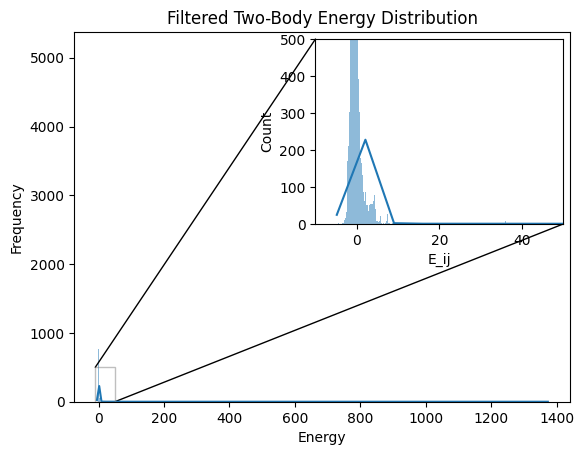

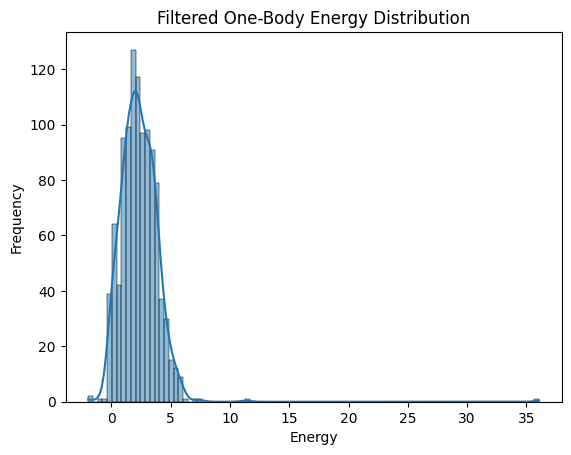

In [29]:
df = pd.read_csv('Energy Files/two_body_terms.csv')
two_energies = df['E_ij']

print(df['E_ij'].describe())

fig, ax = plt.subplots()

sns.histplot(two_energies, kde=True) 
plt.title('Filtered Two-Body Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')

# For the zoom plot
x_zoom_range = [-10, 50] 
y_zoom_range = [0, 500] 

y_max_zoomed = 500 
y_min_zoomed = 0

coordsA = "data"
coordsB = "data"
xy1 = (x_zoom_range[0], y_max_zoomed)
xy2 = (x_zoom_range[1], y_min_zoomed)

ax = plt.gca()
ax_inset = inset_axes(ax, width="50%", height="50%", loc='upper right')

sns.histplot(two_energies, kde=True, ax=ax_inset)
ax_inset.set_xlim(x_zoom_range)
ax_inset.set_ylim(y_zoom_range) 

ax.indicate_inset_zoom(ax_inset)

con1 = ConnectionPatch(xyA=xy1, xyB=xy1, coordsA=coordsA, coordsB=coordsB, axesA=ax, axesB=ax_inset, color="black")
con2 = ConnectionPatch(xyA=xy2, xyB=xy2, coordsA=coordsA, coordsB=coordsB, axesA=ax, axesB=ax_inset, color="black")
ax.add_artist(con1)
ax.add_artist(con2)

plt.show()


df1 = pd.read_csv('Energy Files/one_body_terms.csv')
one_energies = df1['E_ii']

sns.histplot(one_energies, kde=True) 
plt.title('Filtered One-Body Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()


# Filtering of energy distributions 
Filtering the two-body energy distribution of all values further than 3 standard deviations from the mean and filtering the one-body energy distribution of all values further than 6 standard deviations from the mean.

In [27]:
# Defining filtering values for the two-body energy distribution
mean_two = df['E_ij'].mean()
std_two = df['E_ij'].std()

upper_bound2 = mean_two + 3 * std_two

filtered_df = df[(df['E_ij'] <= upper_bound2)]
filtered_df.to_csv('Energy Files/filtered_file_two.csv', index=False)


# Defining filtering values for the one-body energy distribution
mean_one = df1['E_ii'].mean()
std_one = df1['E_ii'].std()

upper_bound1 = mean_one + 6 * std_one

filtered_df1 = df1[(df1['E_ii'] <= upper_bound1)]
filtered_df1.to_csv('Energy Files/filtered_file_one..csv', index=False)
